In [1]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#creating an inspector by importing inspect from sqlalchemy
mlist=[]
inspector = inspect(engine)
# inspector.get_table_names()
for c in inspector.get_columns('measurement'):
    mlist.append(f"Measurement.{c['name']}")
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#performing a select * statement with engine.execute to see how the data looks
engine.execute('SELECT * FROM measurement limit 7').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0)]

In [13]:
#using same as above and creating a dataframe to count items. Reason for DF is to show if any Null items exist

test = engine.execute('SELECT * FROM measurement').fetchall()
pd.DataFrame(test).count()
#Note: few items in 3rd column (precipitation) is Null. Consider this in analysis

0    19550
1    19550
2    19550
3    18103
4    19550
dtype: int64

In [14]:
# extracting the last date from the date column in measurement table/class
lastdate = session.query(Measurement.date).order_by(Measurement.date)[-1][0]
lastdate = dt.datetime.strptime(lastdate, "%Y-%m-%d")
lastdate.strftime("%Y-%m-%d")

'2017-08-23'

In [15]:
lastyear = dt.datetime.today() - dt.timedelta(days=365)
lastyear.strftime("%Y-%m-%d")

'2017-07-28'

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
firstdate = lastdate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcpQRY = session.query(Measurement.date, func.avg(Measurement.prcp)).\
        filter(Measurement.date <= lastdate, Measurement.date >= firstdate).\
        group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(data = prcpQRY, columns=["date","prcp"])
prcpDF.set_index("date",inplace=True)
prcpDF.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


# Exploratory Climate Analysis

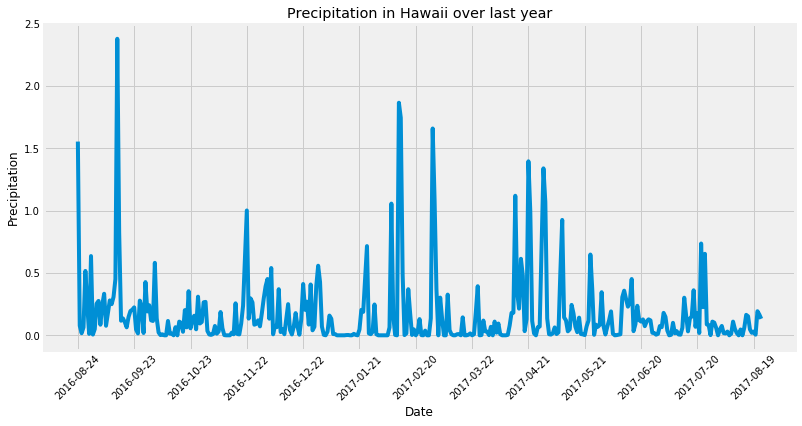

In [17]:
#from matplotlib.ticker import LinearLocator
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(12,6))
x_ticks=prcpDF.index[0::30]
sns.set_style()
plt.plot(prcpDF.index, prcpDF["prcp"])
plt.xticks(x_ticks,x_ticks, visible=True,rotation=45)
plt.title(f"Precipitation in Hawaii over last year")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [19]:
# How many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
stationActivity = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
    
stationActivity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActive = stationActivity[0][0]
lowestTemp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==mostActive).all()[0]
highestTemp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==mostActive).all()[0]
averageTemp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==mostActive).all()[0]

MostActiveDF = pd.DataFrame({
                "Station":mostActive,
                "Lowest Temp":lowestTemp,
                "Highest Temp":highestTemp,
                "Avg Temp":averageTemp,
})

MostActiveDF = MostActiveDF[["Station","Lowest Temp","Highest Temp","Avg Temp"]]
MostActiveDF

,Station,Lowest Temp,Highest Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


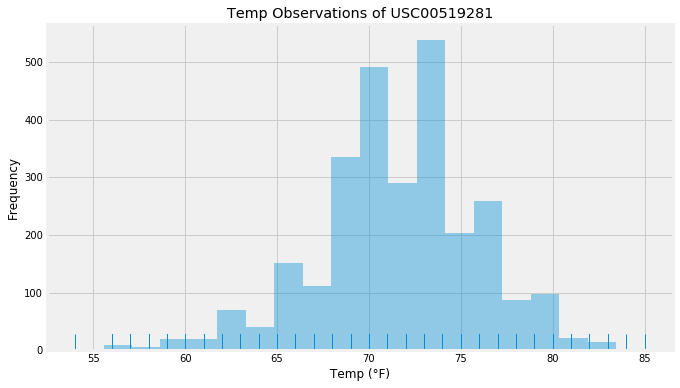

In [22]:

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MostTempObs = session.query(Measurement.tobs).filter(Measurement.station==mostActive).all()
plt.figure(figsize=(10,6))
sns.distplot(MostTempObs, bins=20, kde=False, rug=True);
plt.title(f"Temp Observations of {mostActive}")
plt.ylabel("Frequency")
plt.xlabel("Temp (°F)")
plt.show()

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# startdate = input("Enter start date(Y-M-D): ")
# enddate = input("Enter end date(Y-M-D): ")

def calc_temps(start_date, end_date):

    datefilter = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
        
    TMIN = datefilter[0][0]
    TAVG = round(datefilter[0][1],1)
    TMAX = datefilter[0][2]
    
    print(f"\nFor the dates entered {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}, \nTemp(°F) is as follows:\n   Min Temp: {TMIN}\n   Avg Temp: {TAVG}\n   Max Temp: {TMAX}")
    return TMIN, TAVG, TMAX
# calc_temps(startdate, enddate)

In [29]:
print(f"Please pick dates before {lastdate}")
i = 0
while i == 0:
    vacationStart = input("Please enter a start date for vacation (Y-M-D): ")
    vacationEnd = input("Please enter a end date for vacation (Y-M-D): ")
    vacationStart = dt.datetime.strptime(vacationStart, "%Y-%m-%d")
    vacationEnd = dt.datetime.strptime(vacationEnd, "%Y-%m-%d")

    delta = vacationEnd-vacationStart
    delta = delta.days+1

    if delta < 3 or delta >15:
        print("Not in vacation range, which is 3 to 15 days please redo\n")
        i = 0
    else:
        i = 1


Please pick dates before 2017-08-23 00:00:00
Please enter a start date for vacation (Y-M-D): 2017-6-1
Please enter a end date for vacation (Y-M-D): 2017-6-10


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
TempInfo = calc_temps(vacationStart, vacationEnd)


For the dates entered 2017-06-01 to 2017-06-10, 
Temp(°F) is as follows:
   Min Temp: 72.0
   Avg Temp: 77.5
   Max Temp: 81.0


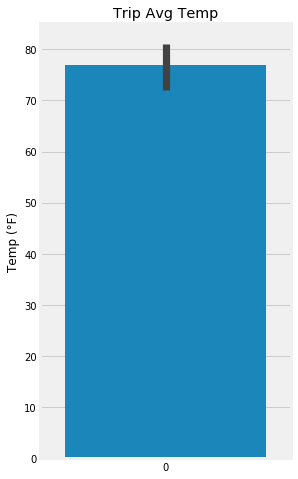

In [31]:
# Plot the results from your previous query as a bar chart. 
plt.figure(figsize=(4,8))
sns.barplot(data=TempInfo)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (°F)")
plt.show()
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [32]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stationQRY = session.query(Measurement.station, func.avg(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date <= vacationEnd.strftime('%Y-%m-%d'), \
               Measurement.date >= vacationStart.strftime('%Y-%m-%d'), \
              Measurement.station == Station.station).\
        group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc()).all()
stationQRY = pd.DataFrame(data=stationQRY, columns=["Station","Avg Prcp", "Name", "Latitude", "Longitude", "Elevation"])
stationQRY

,Station,Avg Prcp,Name,Latitude,Longitude,Elevation
0,USC00516128,0.141667,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.099000,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00514830,0.092000,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00513117,0.073000,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519523,0.028000,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.006000,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
vacayInfo = []
def daily_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    


In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
for x in range(delta):
    date = vacationStart+dt.timedelta(x)
    date = date.strftime("%m-%d")
    normals = daily_normals(date)
    
    normalInfo = {"Date":date ,"Min":normals[0][0], "Avg":round(normals[0][1],1), "Max":normals[0][2]}
    vacayInfo.append(normalInfo)

vacayDF = pd.DataFrame(vacayInfo)
vacayDF = vacayDF[["Date","Min","Avg","Max"]]
vacayDF.set_index("Date",inplace=True)
vacayDF.head()

,Min,Avg,Max
Date,,,
06-01,64.0,74.6,81.0
06-02,65.0,74.4,81.0
06-03,65.0,74.0,80.0
06-04,65.0,73.8,81.0
06-05,68.0,74.9,81.0


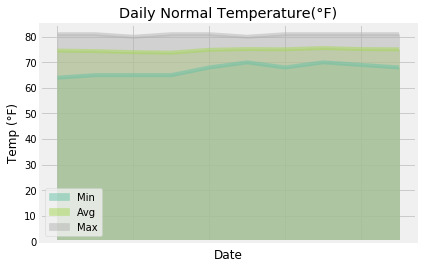

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
vacayDF.plot(kind='area', stacked=False, alpha=.5,  colormap='Set2')
             
plt.title(f"Daily Normal Temperature(°F)")
plt.ylabel("Temp (°F)")
plt.show()